# 4. Docker 基础网络介绍

## 4.1 外部访问容器

容器中可以运行一些网络应用，要让外部也可以访问这些应用，可以通过-P或-p参数来指定端口映射。

当使用-P标记时，Docker会随机映射一个端口到内部容器开放的网络端口。 使用docker container ls可以看到，本地主机的 32768 被映射到了容器的 80 端口。此时访问本机的 32768 端口即可访问容器内 NGINX 默认页面。

for example:

    $ docker run -d -P nginx:alpine

    $ docker container ls -l

同样的，可以通过docker logs命令来查看访问记录

for example:

    $ docker logs fa

-p则可以指定要映射的端口，并且，在一个指定端口上只可以绑定一个容器。

支持的格式有ip:

    hostPort:containerPort | ip::containerPort | hostPort:containerPort

### 4.1.1 映射所有接口地址

使用hostPort:containerPort格式本地的 80 端口映射到容器的 80 端口，可以执行

for example:

    $ docker run -d -p 80:80 nginx:alpine

此时默认会绑定本地所有接口上的所有地址。

### 4.1.2 映射到指定地址的指定端口

可以使用ip:hostPort:containerPort格式指定映射使用一个特定地址，比如localhost地址127.0.0.1

for example:

    $ docker run -d -p 127.0.0.1:80:80 nginx:alpine

### 4.1.3 映射到指定地址的任意端口

使用ip::containerPort绑定localhost的任意端口到容器的80端口，本地主机会自动分配一个端口。

for example:

    $ docker run -d -p 127.0.0.1::80 nginx:alpine

还可以使用udp标记来指定udp端口

for example:

    $ docker run -d -p 127.0.0.1:80:80/udp nginx:alpine

### 4.1.4 查看映射端口配置

使用docker port来查看当前映射的端口配置，也可以查看到绑定的地址

for example:

    $ docker port fa 80
    0.0.0.0:32768

注意： 容器有自己的内部网络和 ip 地址（使用docker inspect查看，Docker还可以有一个可变的网络配置。） -p标记可以多次使用来绑定多个端口

for example:

    $ docker run -d \
        -p 80:80 \
        -p 443:443 \
        nginx:alpine

## 4.2 容器互联

### 4.2.1 新建网络

    $ docker network create -d bridge my-net

-d参数指定Docker网络类型，有bridge overlay,其中overlay网络类型用于Swarm mode，在本小节中你可以忽略它。

### 4.2.2 连接容器

运行一个容器并连接到新建的my-net网络

    $ docker run -it --rm --name busybox1 --network my-net busybox sh

打开新的终端，再运行一个容器并加入到 my-net网络

    $ docker run -it --rm --name busybox2 --network my-net busybox sh

再打开一个新的终端查看容器信息

    $ docker container ls

在busybox1容器输入以下命令

    / # ping busybox2
    PING busybox2 (172.19.0.3): 56 data bytes
    64 bytes from 172.19.0.3: seq=0 ttl=64 time=0.072 ms
    64 bytes from 172.19.0.3: seq=1 ttl=64 time=0.118 ms
    
同理在busybox2容器执行ping busybox1，也会成功连接到。

    / # ping busybox1
    PING busybox1 (172.19.0.2): 56 data bytes
    64 bytes from 172.19.0.2: seq=0 ttl=64 time=0.064 ms
    64 bytes from 172.19.0.2: seq=1 ttl=64 time=0.143 ms
    
这样，busybox1 容器和 busybox2 容器建立了互联关系

## 4.3 配置DNS

自定义配置容器的主机名和 DNS

在容器中使用 mount命令可以看到挂载信息：

    $ mount
    /dev/disk/by-uuid/1fec...ebdf on /etc/hostname type ext4 ...
    /dev/disk/by-uuid/1fec...ebdf on /etc/hosts type ext4 ...
    tmpfs on /etc/resolv.conf type tmpfs ...

这种机制可以让宿主主机 DNS 信息发生更新后，所有Docker容器的 DNS 配置通过 /etc/resolv.conf文件立刻得到更新。

配置全部容器的 DNS ，也可以在 /etc/docker/daemon.json 文件中增加以下内容来设置。

    {
      "dns" : [
        "114.114.114.114",
        "8.8.8.8"
      ]
    }

这样每次启动的容器 DNS 自动配置为 114.114.114.114 和8.8.8.8。使用以下命令来证明其已经生效。

    $ docker run -it --rm ubuntu:18.04  cat etc/resolv.conf

    nameserver 114.114.114.114
    nameserver 8.8.8.8

如果用户想要手动指定容器的配置，可以在使用docker run命令启动容器时加入如下参数： -h HOSTNAME或者--hostname=HOSTNAME设定容器的主机名，它会被写到容器内的/etc/hostname 和 /etc/hosts。但它在容器外部看不到，既不会在docker container ls中显示，也不会在其他的容器的/etc/hosts看到。

--dns=IP_ADDRESS添加 DNS 服务器到容器的/etc/resolv.conf中，让容器用这个服务器来解析所有不在 /etc/hosts 中的主机名。

--dns-search=DOMAIN设定容器的搜索域，当设定搜索域为.example.com时，在搜索一个名为host的主机时，DNS 不仅搜索 host，还会搜索host.example.com。

**注意：**如果在容器启动时没有指定最后两个参数，Docker会默认用主机上的/etc/resolv.conf来配置容器。

## 4.4 Docker的网络模式

**没学过计算机网络，需要学习。**

可以通过docker network ls查看网络，默认创建三种网络。

    [root@localhost ~]# docker network ls
    NETWORK ID          NAME                DRIVER              SCOPE
    688d1970f72e        bridge              bridge              local
    885da101da7d        host                host                local
    f4f1b3cf1b7f        none                null                local


    网络模式	 简介
    Bridge	   为每一个容器分配、设置 IP 等，并将容器连接到一个 docker0 虚拟网桥，默认为该模式。
    Host	     容器将不会虚拟出自己的网卡，配置自己的 IP 等，而是使用宿主机的 IP 和端口。
    None	     容器有独立的 Network namespace，但并没有对其进行任何网络设置，如分配 veth pair 和网桥连接，IP 等。
    Container	新创建的容器不会创建自己的网卡和配置自己的 IP，而是和一个指定的容器共享 IP、端口范围等。

### 4.4.1 Bridge模式

当Docker进程启动时，会在主机上创建一个名为docker0的虚拟网桥，此主机上启动的Docker容器会连接到这个虚拟网桥上，附加在其上的任何网卡之间都能自动转发数据包。虚拟网桥的工作方式和物理交换机类似，这样主机上的所有容器就通过交换机连在了一个二层网络中。从docker0子网中分配一个 IP 给容器使用，并设置 docker0 的 IP 地址为容器的默认网关。在主机上创建一对虚拟网卡veth pair设备，Docker 将 veth pair 设备的一端放在新创建的容器中，并命名为eth0（容器的网卡），另一端放在主机中，以vethxxx这样类似的名字命名，并将这个网络设备加入到 docker0 网桥中。可以通过brctl show命令查看。

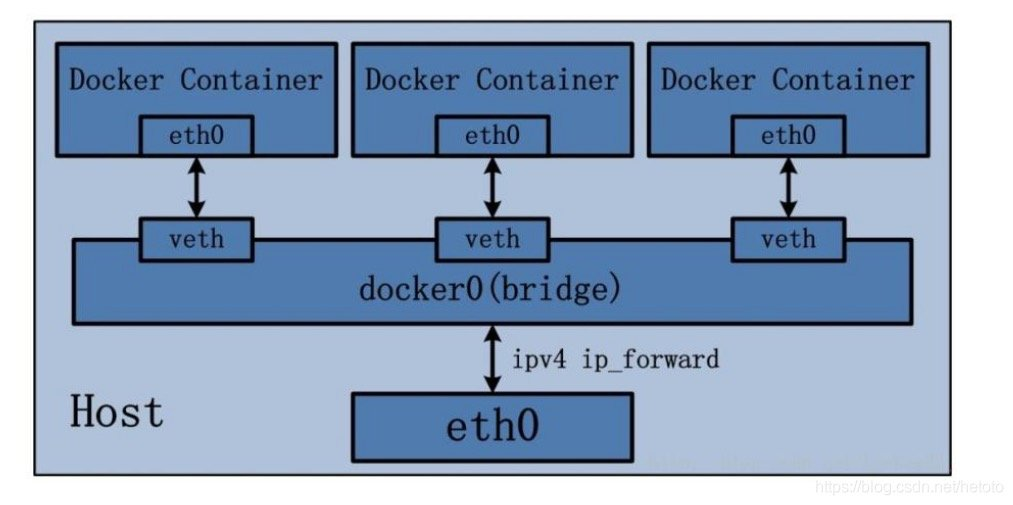

### 4.4.2 Host 模式

1. host 网络模式需要在创建容器时通过参数 --net host 或者 --network host 指定；
2. 采用 host 网络模式的 Docker Container，可以直接使用宿主机的 IP 地址与外界进行通信，若宿主机的 eth0 是一个公有 IP，那么容器也拥有这个公有 IP。同时容器内服务的端口也可以使用宿主机的端口，无需额外进行 NAT 转换；
3. host 网络模式可以让容器共享宿主机网络栈，这样的好处是外部主机与容器直接通信，但是容器的网络缺少隔离性。

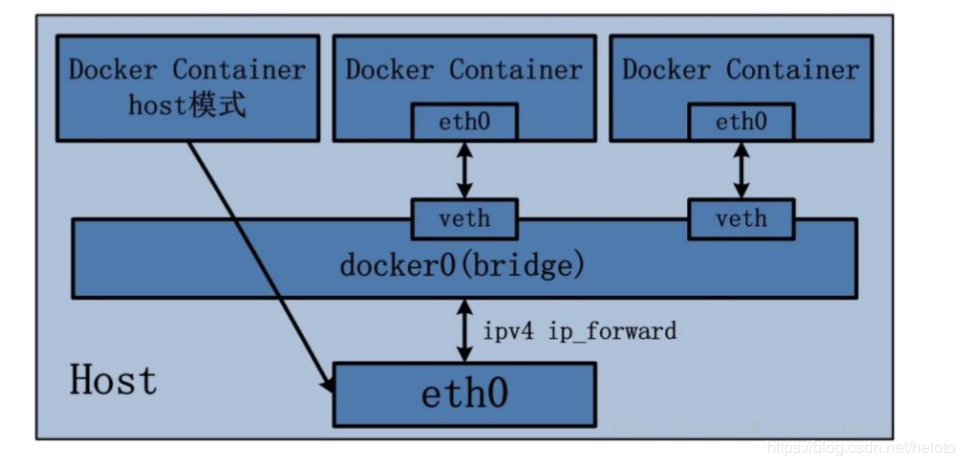

### 4.4.3 None模式

1. none 网络模式是指禁用网络功能，只有 lo 接口 local 的简写，代表 127.0.0.1，即 localhost 本地环回接口。在创建容器时通过参数 --net none 或者 --network none 指定；
2. none 网络模式即不为 Docker Container 创建任何的网络环境，容器内部就只能使用 loopback 网络设备，不会再有其他的网络资源。可以说 none 模式为 Docke Container 做了极少的网络设定，但是俗话说得好“少即是多”，在没有网络配置的情况下，作为 Docker 开发者，才能在这基础做其他无限多可能的网络定制开发。这也恰巧体现了 Docker 设计理念的开放。

### 4.4.4 Container 模式

1. Container 网络模式是 Docker 中一种较为特别的网络的模式。在创建容器时通过参数 --net container:已运行的容器名称|ID 或者 --network container:已运行的容器名称|ID 指定；
2. 处于这个模式下的 Docker 容器会共享一个网络栈，这样两个容器之间可以使用 localhost 高效快速通信。

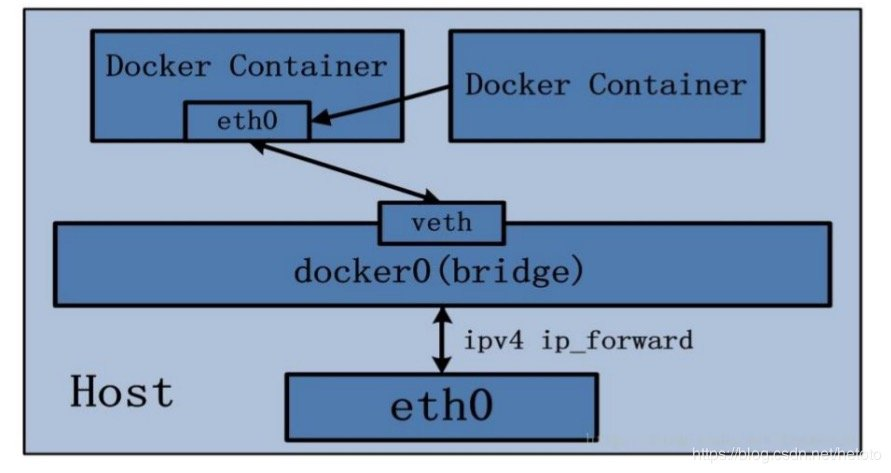

Container 网络模式即新创建的容器不会创建自己的网卡，配置自己的 IP，而是和一个指定的容器共享 IP、端口范围等。同样两个容器除了网络方面相同之外，其他的如文件系统、进程列表等还是隔离的。

## 4.5 高级网络配置

    -b BRIDGE 或 --bridge=BRIDGE 指定容器挂载的网桥
    --bip=CIDR定制 docker0 的掩码
    -H SOCKET... 或 --host=SOCKET... Docker 服务端接收命令的通道
    --icc=true|false 是否支持容器之间进行通信
    --ip-forward=true|false 请看下文容器之间的通信
    --iptables=true|false 是否允许 Docker 添加 iptables 规则
    --mtu=BYTES 容器网络中的 MTU
    
下面2个命令选项既可以在启动服务时指定，也可以在启动容器时指定。在 Docker服务启动的时候指定则会成为默认值，后面执行 docker run 时可以覆盖设置的默认值。

    --dns=IP_ADDRESS... 使用指定的DNS服务器
    --dns-search=DOMAIN... 指定DNS搜索域
    
最后这些选项只有在 docker run 执行时使用，因为它是针对容器的特性内容。

    -h HOSTNAME 或 --hostname=HOSTNAME 配置容器主机名
    --link=CONTAINER_NAME:ALIAS 添加到另一个容器的连接
    --net=bridge|none|container:NAME_or_ID|host 配置容器的桥接模式
    -p SPEC 或 --publish=SPEC` 映射容器端口到宿主主机
    -P or --publish-all=true|false 映射容器所有端口到宿主主机

确实不懂。。。

之后了解